In [140]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv1D, UpSampling1D, Dropout, Flatten, Reshape
from keras.models import Model
from keras import backend as K

import numpy as np


In [ ]:
import obspy
stream = obspy.read('hawaii_Apr-Aug-2018_mag31.5_POHA_waveforms_FILTERED.mseed')
stream.normalize()
tr = stream.traces
X = np.array([t.data[:800] for t in tr])
X = X.reshape(X.shape[0], X.shape[1], 1)

# Create a 1D causal convolutional autoencoder for seismogram feature extraction

based on https://blog.keras.io/building-autoencoders-in-keras.html, https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Conv_Intro.ipynb

In [152]:
# Maybe I should class this

def build_model(latent_dims, input_shape, n_filters=32, dilation_rate=2, n_layers=4):
    
    # ENCODER
    input_layer = Input(shape=input_shape)  # adapt this if using `channels_first` image data format
    x = input_layer
    
    for i in [dilation_rate**i for i in range(n_layers)]:
        x = Conv1D(n_filters, 2, dilation_rate=i, activation='relu', padding='causal')(x)

    #encoder = Dense(128, activation='relu')(x)
    encoder = Flatten()(x)
    latent = Dense(latent_dims)(encoder)

    # DECODER
    decoder = Reshape((1,latent_dims))(latent)
    decoder = Dense(800, activation='relu')(decoder)
    decoder = Reshape((800,1))(decoder)
    x = decoder
    
    for i in [dilation_rate**i for i in range(n_layers)][::-1][:-1]:
        #last step should be a dilatation of 1, skip this to put a sigmoid activation on last layer
        x = Conv1D(n_filters, 2, dilation_rate=i,activation='relu', padding='causal')(x)
        #x = UpSampling1D(2)(x)      

    decoded = Conv1D(n_filters, 2, dilation_rate=1, activation='sigmoid', padding='causal')(x)
    decoded = Dense(input_shape[1])(decoded)

    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, latent)
    #decoder = Model(latent, decoded)
    
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder

In [187]:
autoencoder, encoder = build_model(50, (800,1))

In [188]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 800, 1)            0         
_________________________________________________________________
conv1d_154 (Conv1D)          (None, 800, 32)           96        
_________________________________________________________________
conv1d_155 (Conv1D)          (None, 800, 32)           2080      
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 800, 32)           2080      
_________________________________________________________________
conv1d_157 (Conv1D)          (None, 800, 32)           2080      
_________________________________________________________________
flatten_11 (Flatten)         (None, 25600)             0         
_________________________________________________________________
dense_60 (Dense)             (None, 50)                1280050   
__________

In [ ]:
autoencoder.fit(X[:1000],X[:1000], batch_size=64, epochs=500)

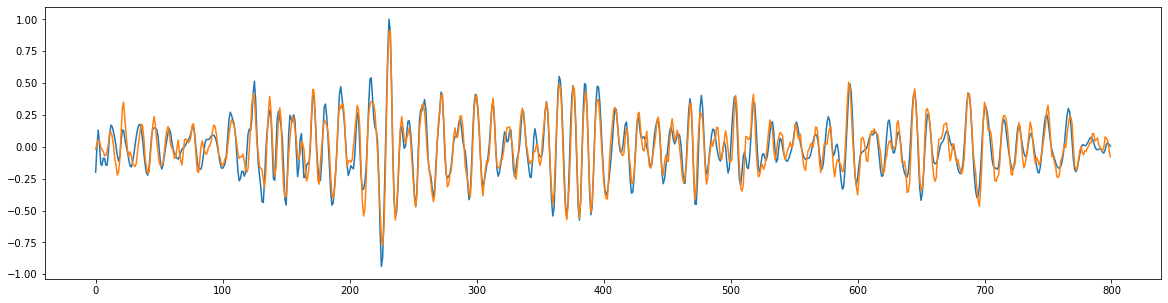

In [196]:
fig = plt.figure(figsize=(20,5))

j = 90
plt.plot(X[j])
predict = autoencoder.predict(X[j].reshape(1,800,1))
plt.plot(predict.reshape(800))

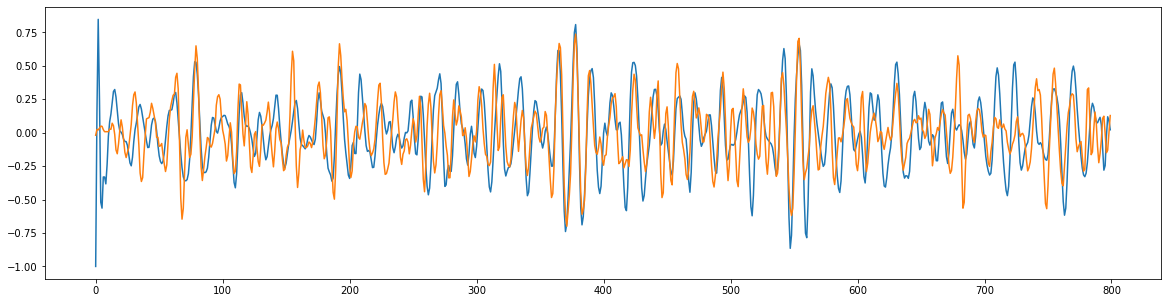

In [197]:
fig = plt.figure(figsize=(20,5))

j = 10000
plt.plot(X[j])
predict = autoencoder.predict(X[j].reshape(1,800,1))
plt.plot(predict.reshape(800))

In [198]:
encoder.compile(optimizer='adam', loss='mse')

In [200]:
latent_vectors = encoder.predict(X.reshape(X.shape[0],800,1))

In [204]:
from sklearn.cluster import KMeans

kmeans = KMeans(5)
clusters = kmeans.fit(latent_vectors)

In [205]:
from sklearn.manifold import TSNE

ts = TSNE(perplexity=40).fit_transform(latent_vectors)

plt.scatter(ts, c=clusters)

TypeError: scatter() missing 1 required positional argument: 'y'